In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

EXPORT_DPI = 100
EXPORT_FIG_SIZE = (8, 4)
EXPORT_FIG_SIZE_BIG = (10, 7)
EXPORT_FIG_WIDTH, EXPORT_FIG_HEIGHT = EXPORT_FIG_SIZE
EXPORT_FIG_WIDTH_BIG, EXPORT_FIG_HEIGHT_BIG = EXPORT_FIG_SIZE_BIG

import pandas as pd

pd.options.display.max_rows = 80
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

import seaborn as sns
import matplotlib.pyplot as plt
sns.set('notebook', 'whitegrid', palette = 'deep')
plt.rcParams['figure.figsize'] = EXPORT_FIG_SIZE_BIG

In [9]:
from utils import dataset_helper
from transformers.nx_graph_to_tuple_transformer import NxGraphToTupleTransformer
import numpy as np
import collections
import re

tuple_trans = NxGraphToTupleTransformer()

graph_sets = {}
for cache_file in dataset_helper.get_all_cached_graph_datasets('ling-spam'):
    graph_type = re.findall(r'dataset_graph_(.+?)_', cache_file)[0]
    if graph_type == 'gml': graph_type = 'concept-map'
    if graph_type in graph_sets: continue
    X, Y = dataset_helper.get_dataset_cached(cache_file)
    graph_sets[graph_type] = (cache_file, X, Y)

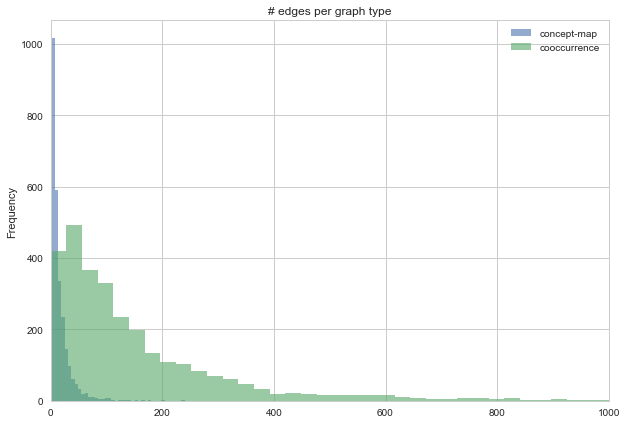

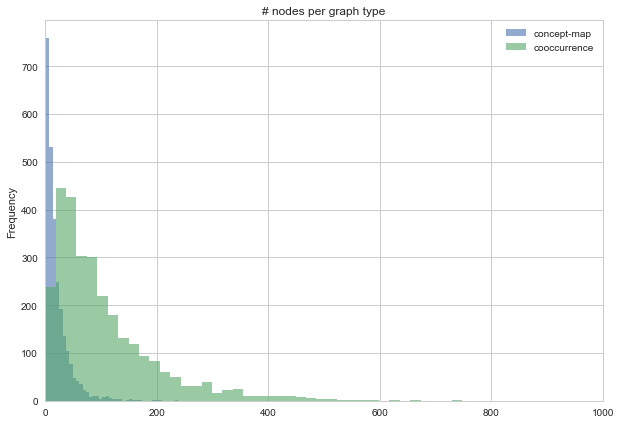

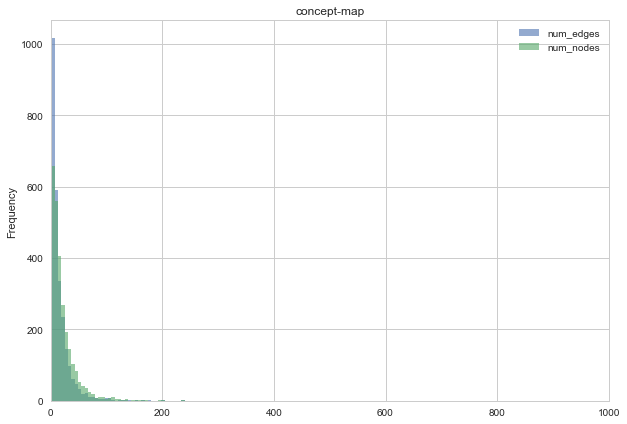

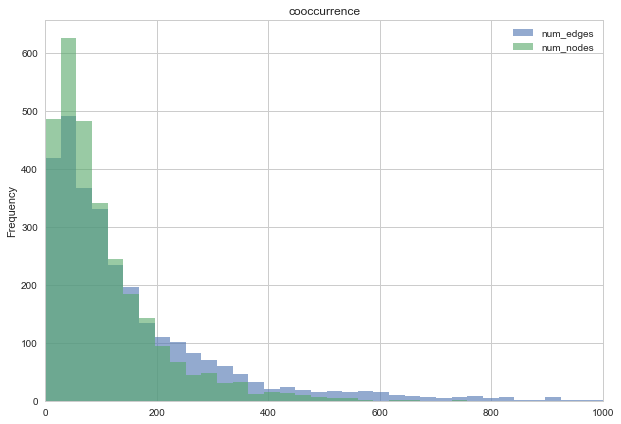

In [10]:
import networkx as nx
import pandas as pd

df = pd.DataFrame()
for graph_type, (cache_file, X, Y) in graph_sets.items():
    df = df.append(pd.DataFrame({
        'graph_type': graph_type,
        'num_nodes': [nx.number_of_nodes(x) for x in X],
        'num_edges': [nx.number_of_edges(x) for x in X]
    }))

hist_kwargs = dict(kind = 'hist', alpha = 0.6, bins = 40, logy = False, legend = True, xlim = (0, 1000))

plt.figure()
df.groupby('graph_type').num_edges.plot(title = '# edges per graph type',**hist_kwargs)
plt.figure()
df.groupby('graph_type').num_nodes.plot(title = '# nodes per graph type', **hist_kwargs)
axes = df.groupby('graph_type').plot(**hist_kwargs)

for name, ax in axes.items():
    ax.set_title(name)

In [ ]:
df.groupby('graph_type').num_nodes.sum() / df.groupby('graph_type').num_edges.sum()
df.groupby('graph_type').num_nodes.sum(), df.groupby('graph_type').num_edges.sum()

In [ ]:
X, Y = dataset_helper.get_dataset('ng20')
for 

In [ ]:
adjs = [adj for adj, _ in X]

adjs_1 = np.copy(adjs)
adjs_2 = np.copy(adjs)

In [ ]:
%%time
for adj in adjs_1:
    adj[adj.nonzero()] = 1

In [ ]:
%%time
for adj in adjs_2:
    adj = adj.tocsr()
    adj.data = np.where(adj.data > 1, 0, 1)

In [ ]:
for a1, a2 in zip(adjs_1, adjs_2):
    break

In [ ]:
colors_all = np.array([[1, 2, 3, 4, 1], [5, 6, 7, 8, 5]])
colors_all = [hash(tuple(row)) for row in colors_all.T]
_, colors_all = np.unique(colors_all, return_inverse=True)
max_all = int(np.amax(colors_all)) + 1
colors_all

## Similar graphs by WL feature map


### Retrieve graph datasets (both cmap and coo)

Retrieve phi feature maps for coo and cmap, then get number of non-zero elements per graph (= per row of the feature map)

And calculate the gram matrix, then find the most similar graphs per graph (= per row of the gram matrix)


In [ ]:
import dataset_helper
import numpy as np
import collections

dataset_name = 'ng20'
dataset_name = 'ling-spam'

results = collections.defaultdict(lambda: {})
for graph_phi_file in dataset_helper.get_all_cached_graph_phi_datasets(dataset_name=dataset_name):
    if 'gml' not in graph_phi_file: continue
    print('Processing: {}'.format(graph_phi_file.split('/')[-1]))
    phi, Y = dataset_helper.get_dataset_cached(graph_phi_file, check_validity=False)
    
    for h, phi_used in enumerate(phi):
        print('\th={}'.format(h))
        # Generate kernel matrix
        gram_matrix = phi_used.dot(phi_used.T).toarray()
        results[graph_phi_file][h] = {}
        results[graph_phi_file][h]['phi_used'] = phi_used
        # Vector with the number of non-zero elements per row
        # ie. non_zero_elements[idx] = len(phi_used[idx].nonzero())
        results[graph_phi_file][h]['non_zero_elements'] = np.squeeze(np.asarray(np.sum(phi_used, axis = 1).T))
        results[graph_phi_file][h]['num_elements'] = phi_used.shape[0]
        results[graph_phi_file][h]['found_counter'] = collections.Counter()
        results[graph_phi_file][h]['most_similar_scores'] = []
        results[graph_phi_file][h]['similarity_pairs'] = []

        for idx, row in enumerate(gram_matrix):
            indices = np.argsort(row)[-10:]
            # Search for index of this graph in the similar graph indices,
            # it should be the most similar graph (because it's the same graph!)
            results[graph_phi_file][h]['found_counter']['found' if idx in indices else 'not_found'] += 1
            results[graph_phi_file][h]['most_similar_scores'].append(row[indices].tolist())
            results[graph_phi_file][h]['similarity_pairs'].append(indices)
print('Finished')

### Plot sparsity of feature maps

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


for graph_cache_file, iterations in results.items():
    fig, ax = plt.subplots(figsize = EXPORT_FIG_SIZE_BIG)
    if 'gml' not in graph_cache_file and 'cooccurrence_1_all_ling' not in graph_cache_file: continue
    for iteration, metrics in iterations.items():
        if iteration != 0: continue
        df = pd.DataFrame(metrics['non_zero_elements'], columns=['non_zero_elements'])
        df.non_zero_elements.plot(kind='hist', bins = 40, alpha = 0.8, ax = ax, title = 'Histogram of non-zero entries in feature map (per row/element)')
    
    ax.set_xlim((0, 1000))
    ax.set_xlabel('# of non-zero elements per row')
    ax.legend(['Co-occurence graphs', 'Concept maps'])
    plt.show()
    fig.savefig('tmp/feature-map-sparsity-{}.png'.format(dataset_name), dpi = EXPORT_DPI)
    plt.close(fig)

### Get graph dataset for the feature map

In [ ]:
print(list(filter(lambda x: 'gml' in x, results.keys())))
graph_phi_file = 'data/CACHE/dataset_graph_gml_ling-spam-single.phi.npy'

In [ ]:
filename = graph_phi_file.split('/')[-1].split('.phi')[0]
print(filename)
candidates = [x for x in dataset_helper.get_all_cached_graph_datasets() if filename in x]
assert len(candidates)
X, Y = dataset_helper.get_dataset_cached(candidates[0])

In [ ]:
import networkx as nx
for i in range(10):
    fig, ax = plt.subplots()
    choice = np.random.choice(len(X))
    graph = nx.Graph(X[choice])
    res = [(node, val) for node, val in nx.pagerank(graph).items()]
    nodes = [node for node, val in res]
    node_vals = np.array([val for node, val in res])
    node_sizes = np.exp(node_vals * 20) * 20 / len(nodes) * 3
    node_sizes = [0 for x in nodes]
    nx.draw_networkx(graph, nodelist = nodes, with_labels=False, node_size = node_sizes, node_color='#000000')
    ax.set_title('Graph#={}, connected_components={}'.format(choice, nx.number_connected_components(graph)))
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_color('#FFFFFF')
    plt.show()


In [ ]:
X_text, _ = dataset_helper.get_dataset(dataset_name)

### Plot similar graphs

In [ ]:
# X
similarity_pairs = results[graph_phi_file]['similarity_pairs']
similarity_scores = np.array(results[graph_phi_file]['most_similar_scores'])
phi_used = results[graph_phi_file]['phi_used']

# Check that the similarity score can not be greater than the number of nodes!
for idx, graph, most_similar, most_similar_score in zip(range(len(X)), X, similarity_pairs, similarity_scores):
    assert max(most_similar_score) <= len(graph.nodes())

In [ ]:
gram_matrix = phi_used.dot(phi_used.T).toarray()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

similarity_pairs = results[graph_phi_file]['similarity_pairs']
similarity_scores = np.array(results[graph_phi_file]['most_similar_scores'])

def get_similarity(graph1_idx, graph2_idx):
    return gram_matrix[graph1_idx, graph2_idx]

def get_non_zero_phi_elements(idx):
    return phi_used[idx].nonzero()[1]

def plot_similar_graphs(graph_idx, num_to_plot = 2):
    most_similar = np.argsort(gram_matrix[graph_idx])
    filtered = [idx for idx in most_similar if nx.number_of_nodes(X[idx]) > 0 and idx != graph_idx and get_similarity(graph_idx, idx) != 0]
    similar_graph_idxs = np.array(filtered[-num_to_plot:])
    graph_idxs = [graph_idx] + similar_graph_idxs.tolist()
    similarities = [get_similarity(graph_idx, idx) for idx in graph_idxs]
    similar_labels = [set(X[idx].nodes()) & set(X[graph_idx].nodes()) for idx in graph_idxs]
    reference_graph = X[graph_idx]
    
    print(phi_used.shape[0], gram_matrix.shape[0])
    print('Graph={}'.format(graph_idx))
    print('NonZeroPhi={}'.format(get_non_zero_phi_elements(graph_idx)))
    print('SimilarOwn={}'.format(get_similarity(graph_idx, graph_idx)))
    print('SimilarIdxs={}'.format(similar_graph_idxs))
    print('Similarities={}'.format(similarities))
    print('SimilarLabels={}'.format(similar_labels))
    
    for similar_graph_idx, graph, text in [(graph_idx, X[graph_idx], X_text[graph_idx]) for graph_idx in graph_idxs]:
        graph = graph.copy()
        graph.remove_nodes_from(set(graph.nodes()) - set(reference_graph.nodes()))
        print(Y[graph_idx], Y[similar_graph_idx])
        fig, ax = plt.subplots(figsize = EXPORT_FIG_SIZE)
        nx.draw_circular(graph, ax = ax, node_size = 14, with_labels = True, node_color = '#000000')
        ax.text(0, 0, str(similar_graph_idx))

for i in range(3):
    print("?")
    random_choice = 1000
    while nx.number_of_nodes(X[random_choice]) > 10:
        random_choice = np.random.randint(0, len(X))
    #random_choice = 1
    plot_similar_graphs(random_choice)
    plt.show()


## Augment edges

Add an edge from node1 to node2 if they are connected by a path of length N

In [ ]:
import dataset_helper
import collections
import networkx as nx
import sys
import copy

WALK_LENGTH = 2
dataset_name = 'ng20'

for graph_cache_file in dataset_helper.get_all_cached_graph_datasets(dataset_name=dataset_name):
    if 'coo' not in graph_cache_file or 'all' in graph_cache_file: continue
    print(graph_cache_file)
    X_old, Y_old = dataset_helper.get_dataset_cached(graph_cache_file)
    
    # TODO
    X_old, Y_old = X_old[:10], Y_old[:10]
    
    X, Y = copy.deepcopy(X_old), copy.deepcopy(Y_old)
    for idx, graph in enumerate(X):
        if idx % 100 == 0: sys.stdout.write('\r{:3.0f}%'.format(idx / len(X) * 100))
        if graph.number_of_edges() == 0 or graph.number_of_nodes() == 0: continue
        shortest_paths = nx.all_pairs_shortest_path(graph, cutoff=WALK_LENGTH)
        for source, target_dict in shortest_paths.items():
            for target, path in target_dict.items():
                graph.add_edge(source, target, attr_dict = {'weight': 1 / len(path)})
    break

## Distribution of classes per dataset

In [ ]:
from IPython.display import display
import collections
df = pd.DataFrame(columns = ['dataset', 'label', 'counts'])
df['counts'] = df['counts'].astype(np.uint64)

for dataset in dataset_helper.get_all_available_dataset_names():
    if 'ana' in dataset: continue
    #if dataset not in dataset_helper.DATASETS_LIMITED: continue
    X, Y = dataset_helper.get_dataset(dataset)
    label_counter = collections.Counter(Y)
    df = df.append(pd.DataFrame([(dataset, label, count) for label, count in label_counter.items()], columns = df.columns), )

for dataset, items in df.groupby('dataset'):
    fig, ax = plt.subplots(figsize = EXPORT_FIG_SIZE_BIG)
    num_els = items.counts.sum()
    stdd = (items.counts / num_els).std()
    items = items.set_index('label')
    items.sort_values('counts').counts.plot(kind = 'barh', title = 'Dataset: {}, stdd/#docs: {:.2f}'.format(dataset, stdd))
    plt.show()
    plt.close(fig)


## Graph statistics

Retrieves concept-maps and coo-graphs graph datasets

In [ ]:
import dataset_helper
import numpy as np
import functools
import collections

# Tuples of: (dataset_name, graph_type, (X, Y))
# For cooccurrence graphs, it will hold a (random) choice for each window size
graph_datasets = []
for dataset in ['ling-spam']:
    print('{:30} start'.format(dataset))
    graph_cache_files = dataset_helper.get_all_cached_graph_datasets(dataset_name=dataset)
    gml_graph_cache = [x for x in graph_cache_files if 'gml' in x][0]
    coo_graph_caches = [x for x in graph_cache_files if 'cooc' in x]
    
    def get_window_size(graph_cache_file):
        return graph_cache_file.split('cooccurrence_')[1].split('_')[0]
    
    coo_graphs_by_window_size = collections.defaultdict(lambda: [])
    for cache_file in coo_graph_caches:
        coo_graphs_by_window_size[get_window_size(cache_file)].append(cache_file)

    graph_datasets.append((dataset, 'concept-graph', dataset_helper.get_dataset_cached(gml_graph_cache)))
    for window_size, cached_files in sorted(coo_graphs_by_window_size.items(), key=lambda x: x[0]):
        # Take random element from the co-occurence graph datasets
        coo_graph_cache = np.random.choice(cached_files)
        print('\tRetrieving co-occurence graphs for window_size={} ({})'.format(window_size, coo_graph_cache))
        graph_datasets.append((dataset, 'coo-{}'.format(window_size), dataset_helper.get_dataset_cached(coo_graph_cache)))
    print('{:30} finished'.format(dataset))
    
df_graph_datasets = pd.DataFrame(graph_datasets, columns = ['dataset_name', 'graph_type', 'dataset'])

### Connected components

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

data = []
for dataset, graph_type, (X, Y) in graph_datasets:
    data += [(dataset, graph_type, nx.number_connected_components(graph)) for graph in X]

df_connected_components = pd.DataFrame(data, columns = ['dataset_name', 'graph_type', 'connected_components'])

for dataset, df_dataset in df_connected_components.groupby('dataset_name'):
    for graph_type, df in df_dataset.groupby('graph_type'):
        if graph_type != 'concept-graph': continue
        fig, ax = plt.subplots(figsize = EXPORT_FIG_SIZE)
        df.connected_components.plot(kind = 'hist', bins = 20, title = 'Dataset: {}, graph type: {}'.format(dataset, graph_type))
        ax.set_xlabel('number of connected components')
        fig.tight_layout()
        fig.savefig('tmp/hist-connected-components-{}-{}.png'.format(dataset, graph_type), dpi = EXPORT_DPI)
        plt.show()
        plt.close(fig)

### Density, #nodes, #edges histograms

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

figsize = (16, 4)
NUM_BINS = 60
alpha = 0.6

graph_metrics = [
    ('density', lambda graph: nx.density(graph) if graph.number_of_nodes() > 0 else 0.0),
    ('number of nodes', lambda graph: graph.number_of_nodes()),
    ('number of edges', lambda graph: graph.number_of_edges()),
    ('connected components', lambda graph: nx.number_connected_components(graph)),
    ('num_nodes_div_num_edges', lambda graph:  graph.number_of_nodes() / graph.number_of_edges() if graph.number_of_edges() > 0 else -99),
    ('num_edges_div_num_nodes', lambda graph:  graph.number_of_edges() / graph.number_of_nodes() if graph.number_of_nodes() > 0 else -99)
]

for metric_name, metric in graph_metrics:
    graph_metrics = []
    for dataset, graph_type, (X, Y) in graph_datasets:
        graph_metrics += [(dataset, graph_type, metric(graph)) for graph in X]

    df = pd.DataFrame(graph_metrics, columns = ['dataset', 'graph_type', 'graph_metric'])
    df = df[df.graph_metric > -10]
    fig, ax = plt.subplots(figsize = (EXPORT_FIG_WIDTH + 2, EXPORT_FIG_HEIGHT + 1))
    metrics_ = df.graph_metric.tolist()
    binwidth = (max(metrics_) - min(metrics_)) / NUM_BINS
    bins = np.arange(min(metrics_), max(metrics_) + binwidth, binwidth)
    a = df.groupby('graph_type').graph_metric.plot(kind = 'hist',bins = bins, alpha = alpha, ax = ax, title = 'Histogram of {}'.format(metric_name), logy = True, legend = True)
    medians = df.groupby('graph_type').graph_metric.median()
    for median in medians:
        ax.axvline(median, linewidth=1, alpha = alpha, color='b', linestyle='dashed')
    ax.set_xlabel(metric_name)
    plt.show()
    fig.savefig('tmp/graph-statistics/hist-{}.png'.format(metric_name), dpi = EXPORT_DPI)
    plt.close(fig)
    #ax = sns.violinplot(x = 'graph_type', y = 'graph_densities', data=df, cut = 0, inner = 'quartile')

### Plot examples of graph types
concept map and co-occurrence

In [ ]:
df = pd.DataFrame(graph_datasets, columns = ['dataset', 'graph_type', 'graph_dataset'])

In [ ]:
import matplotlib.pyplot as plt

NUM_GRAPHS_PER_TYPE = 4

for dataset, data in df.groupby('dataset'):
    fig, axes = plt.subplots(ncols=data.graph_type.value_counts().size, nrows=NUM_GRAPHS_PER_TYPE, figsize = EXPORT_FIG_SIZE_BIG)

    for idx, row_ax in enumerate(axes):
        print('Row: {}/{}'.format(idx, len(axes) - 1))
        for (_, item), ax in zip(data.iterrows(), row_ax):
            if idx == 0:
                ax.set_title(item.graph_type)
            X, Y = item.graph_dataset

            random_graph = None
            while not random_graph or nx.number_of_nodes(random_graph) not in range(5, 10):
                random_graph = np.random.choice(X)
                
            #nx.draw_spring(random_graph, ax = ax, node_size = 20)#, style = 'dotted')
            nx.draw_networkx(random_graph, ax = ax, node_size = 14, with_labels = False, node_color = '#000000')#, style = 'dotted')
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid('off')
            for spine in ax.spines.values():
                spine.set_color('#FFFFFF')
    
    fig.tight_layout()
    fig.savefig('tmp/graph-examples.png', dpi = EXPORT_DPI)
    plt.close(fig)

## Plot unique word counts

In [ ]:
import dataset_helper
import sympy
import pandas as pd

word_counts = []
for dataset_name in dataset_helper.get_all_available_dataset_names():
    X, Y = dataset_helper.get_dataset(dataset_name)
    text = []
    for t in X:
        text.append(t)
    text = ' '.join(text)
    text = text.lower().replace('\n', ' ')
    words = [x.strip() for x in text.split() if x.strip() != '']
    unique_words = set(words)
    word_counts.append((dataset_name, len(unique_words), len(words)))

In [ ]:
from preprocessing import preprocessing
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if 'ana' in dataset_name: continue
    print(dataset_name)
    X, Y = dataset_helper.get_dataset(dataset_name)
    X_pp = preprocessing.preprocess_text_spacy(X, concat = False, only_nouns = False)
    break

In [ ]:
import matplotlib.pyplot as plt
df = pd.DataFrame(word_counts, columns = ['dataset', 'unique_words', 'words']).set_index('dataset').sort_values('unique_words')
df['unique_words_ratio'] = df.unique_words / df.words

fig, ax = plt.subplots(figsize = (12, 6))
df[['unique_words', 'words']].plot(kind = 'barh', logx = True, title = 'Unique word count', ax = ax)
fig, ax = plt.subplots(figsize = (12, 6))
df.unique_words_ratio.plot(kind = 'barh', title = '#Unique words/#words', ax = ax);

## Mixed gml classification (single document, merged document)

In [ ]:
import dataset_helper
from kernels import fast_wl
import networkx as nx
import graph_helper
import numpy as np

#'reuters-21578',
for dataset in ['ng20']:
    X, Y = dataset_helper.get_gml_graph_dataset(dataset)

In [ ]:
X_single, Y_single = dataset_helper.get_dataset_cached([x for x in dataset_helper.get_all_cached_graph_datasets(dataset_name='ng20') if 'gml' in x and 'single' in x][0])

In [ ]:
def filter_classes(x, y, classes_to_keep = ()):
    indices = [y_ in classes_to_keep for y_ in y]
    return np.array(x, dtype = object)[indices].tolist(), np.array(y, dtype = object)[indices].tolist()

X_single_filtered, Y_single_filtered = filter_classes(X_single, Y_single, set(Y))

# Compute phi
graph_helper.convert_graphs_to_adjs_tuples(X_single_filtered)
graph_helper.convert_graphs_to_adjs_tuples(X)

In [ ]:
X_merged = np.concatenate([X, X_single_filtered])
Y_merged = np.concatenate([Y, Y_single_filtered])
phi_lists, new_label_lookups, new_label_counters = fast_wl.fast_wl_compute(X_merged.tolist(), h = 4)

In [ ]:
import sklearn
import pandas as pd

svm = sklearn.svm.LinearSVC()
results = []
for idx, phi in enumerate(phi_lists):
    svm.fit(phi.T[:len(X),:], Y)
    Y_pred = svm.predict(phi.T[len(X):,:])
    results.append((idx, sklearn.metrics.f1_score(y_true = Y_single_filtered, y_pred=Y_pred, average = 'micro')))
    #print(sklearn.metrics.classification_report(y_true = Y_single_filtered, y_pred = Y_pred)) #, average='macro')
pd.DataFrame(results, columns = ['phi', 'f1_macro']).set_index('phi')

## DeepWalk

In [ ]:
import deepwalk
from deepwalk import graph
from deepwalk import walks as serialized_walks
from gensim.models import Word2Vec
from deepwalk.skipgram import Skipgram
import dataset_helper
import graph_helper
import random
from gensim.models import Word2Vec
from misc import tsne
import matplotlib.pyplot as plt

max_memory_data_size = 1000000000
number_walks = 1000
representation_size = 64
seed = 0
undirected = True
vertex_freq_degree = False
walk_length = 60
window_size = 10
workers = 1
output = 'data/DUMP'

for dataset in dataset_helper.get_all_available_dataset_names():
    cache_file = dataset_helper.CACHE_PATH + '/dataset_graph_cooccurrence_{}.npy'.format(dataset)
    X, Y = dataset_helper.get_dataset(dataset, preprocessed = False, use_cached=True, transform_fn=graph_helper.convert_dataset_to_co_occurence_graph_dataset, cache_file=cache_file)
    break
    
models = []
for idx, g in enumerate(X):
    if idx == 3: break
    print('Graph: {:>4}'.format(idx))
    G = graph.from_networkx(g)

    print("Number of nodes: {}".format(len(G.nodes())))
    if len(G.nodes()) == 0:
        continue

    num_walks = len(G.nodes()) * number_walks

    print("Number of walks: {}".format(num_walks))

    data_size = num_walks * walk_length

    print("Data size (walks*length): {}".format(data_size))

    print("Walking...")
    walks = graph.build_deepwalk_corpus(G, num_paths=number_walks, path_length=walk_length, alpha=0, rand=random.Random(seed))
    print("Training...")
    model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, workers=workers)

    #model.wv.save_word2vec_format(output)
    models.append(model)
print('Finished')

## tSNE

In [ ]:
for model in models:
    print('Next')
    vectors = tsne.get_tsne_embedding(model)
    tsne.plot_embedding(model, vectors)
    plt.show()

## Test WL phi computation

## Merge node labels

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

num_labels = len(labels)

for (n, treshold), lookup in results.items():
    cliques = coreference.get_cliques_from_lookup(lookup)
    similarity_counter = {'similar': len(lookup.keys()), 'unsimilar': num_labels - len(lookup.keys())}
    clique_lenghts = [len(x) for x in list(cliques.values())]
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))
    fig.suptitle('Treshold: {}, N={}'.format(treshold, n), fontsize = 16)

    pd.DataFrame(clique_lenghts).plot(ax = axes[0], kind = 'hist', logy = True, legend = False, title = "Histogram of clique lengths".format(treshold))
    pd.DataFrame(list(similarity_counter.items()), columns = ['name', 'count']).set_index('name').plot(ax = axes[1], kind = 'bar', legend = False, title = '# of labels that have been merged vs. not merged')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.savefig('tmp/{:.5f}.{}.png'.format(treshold, n), dpi = 120)
    plt.close(fig)

In [ ]:
sns.set('notebook', 'white')
def plot_by(df, by, bins = 15, title = '', figsize = (12, 5), fontsize = 16):
    fig, ax = plt.subplots(figsize = figsize)

    data = []
    labels = []
    for n, vals in df.groupby(by):
        labels.append(n)
        data.append(vals.clique_length)
    ax.hist(data, bins = bins, alpha=0.7, label=labels, log = True)
    fig.suptitle(title, fontsize = fontsize)
    ax.legend(loc='upper right', fontsize = fontsize)
    ax.set_xlabel('clique sizes')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return fig, ax
fig, ax = plot_by(df, 'n', title = 'Clique size histogram by n (all thresholds together)')
fig.savefig('tmp/clique_size_by_n_all_thresholds.png', dpi = 120)
fig, ax = plot_by(df, 'threshold', title = 'Clique size histogram by threshold (all n together)')
fig.savefig('tmp/clique_size_by_threshold_all_n.png', dpi = 120)
fig, ax = plot_by(df[df.threshold == 0.6], 'n', title = 'Clique size histogram by n (threshold=0.6)')
fig.savefig('tmp/clique_size_by_n_threshold_0.6.png', dpi = 120)
plt.show()

In [ ]:
import coreference
for lookup_file in glob('data/embeddings/graph-embeddings/*.threshold-*.*.label-lookup.npy'):
    threshold, topn = get_treshold_and_topn_from_lookupfilename(lookup_file)
    with open(lookup_file, 'rb') as f:
        lookup = pickle.load(f)
    for key in lookup.values():
        if not isinstance(key, (str, int)):
            print("?")
            break
    fig, axes = coreference.plot_lookup_histogram(lookup=lookup, title = 'threshold={}, topn={}'.format(threshold, topn))
    plt.show()
    plt.close(fig)

## Create small dataset

In [ ]:
import dataset_helper
import pickle
import numpy as np
import sklearn
graph_cache_file = 'dataset_graph_gml_ng20-single.npy'
X, Y = dataset_helper.get_dataset_cached('data/CACHE/{}'.format(graph_cache_file))
X, Y = np.array(X, dtype=object), np.array(Y, dtype=object)
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 40, random_state=42)
for train_index, test_index in sss.split(X, Y):
    X_test, Y_test = X[test_index], Y[test_index]
    break
with open('data/CACHE/dataset_graph_gml_small-single.npy', 'wb') as f:
    pickle.dump((X_test.tolist(), Y_test.tolist()), f)    

## Statistics

In [ ]:
from utils import dataset_helper
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

sns.set('notebook', 'white')
limit_dataset = ['ng20', 'ling-spam', 'reuters-21578', 'webkb']
limit_dataset = ['ling-spam']
all_stats = {}
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if dataset_name not in limit_dataset: continue
    print(dataset_name)
    X, Y = dataset_helper.get_dataset(dataset_name)
    graphs = dataset_helper.get_all_cached_graph_datasets(dataset_name)
    number_of_nodes = []
    
    coo_graph = [x for x in graphs if 'cooccurrence' in x][0]
    gml_graph = [x for x in graphs if 'gml' in x][0]
    
    def get_num_nodes(graph_file):
        X_graph, _ = dataset_helper.get_dataset_cached(graph_file)
        return [nx.number_of_nodes(x) for x in X_graph]
    
    stats = {
        'cooccurrence': get_num_nodes(coo_graph),
        'concept-graphs': get_num_nodes(gml_graph)
    }
    
    min_len = min([len(v) for k, v in stats.items()])
    graph_stats = {k: v[:min(min_len, len(v))] for k, v in stats.items()}
    text_stats = {'doc_lengths': [len(x) for x in X]}
    
    all_stats[dataset_name] = {
        'graphs': graph_stats,
        'text': text_stats['doc_lengths'],
        'num_docs': len(X),
        'num_classes': len(set(Y))
    }


In [ ]:
bins = 20

for dataset_name, stats in all_stats.items():
    graph_stats = stats['graphs']
    text_stats = stats['text']
    
    df = pd.DataFrame(graph_stats)
    
    fig, ax = plt.subplots(nrows = 1, ncols=2)
    df.plot(kind = 'hist', bins=bins, alpha = 0.7, logy = True, ax=ax[0])
    ax[0].set_xlabel('# nodes per graph')
    
    df = pd.DataFrame(text_stats)
    df.plot(kind = 'hist', bins=bins, logy = True, legend = False, ax=ax[1])
    ax[1].set_xlabel('# characters per document')
    fig.savefig('tmp/other/stats-{}.png'.format(dataset_name), dpi = 150)
    plt.show()

In [ ]:
import numpy
out = []
for dataset, stats in all_stats.items():
    out.append((dataset, np.mean(stats['text']), np.mean(stats['graphs']['cooccurrence']), np.mean(stats['graphs']['concept-graphs']), stats['num_docs'], stats['num_classes']))
    
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8, 6))

df = pd.DataFrame(out, columns = ['dataset', 'avg_doc_length', 'avg_coo_node_num', 'avg_cp_node_num', 'num_docs', 'num_classes'])
df = df.set_index('dataset')
#, ('# classes', 'num_classes')
for idx, (name, x) in enumerate([('Average document length', 'avg_doc_length'), ('# documents', 'num_docs'), ('Average of number of concept-graph nodes', 'avg_cp_node_num')]):
    ax = axes[idx]
    df[x].plot(kind = 'barh', logx = True, title = name, ax = ax)
    
fig.tight_layout()
fig.savefig('tmp/other/stats-datasets.png', dpi = 100)
plt.show()

## Label count histogram

In [ ]:
import dataset_helper
import graph_helper
import collections
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

counts = []
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if dataset_name not in ['ling-spam', 'ng20', 'webkb', 'reuters-21578']: continue
    graph_cache_files = dataset_helper.get_all_cached_graph_datasets(dataset_name)
    if not len(graph_cache_files): continue
    for graph_cache_file in graph_cache_files:
        #if 'gml' not in graph_cache_file: continue
        if 'gml' in graph_cache_file: continue
        print('Loading dataset: {}'.format(graph_cache_file))
        X_old, _ = dataset_helper.get_dataset_cached(graph_cache_file)
        label_counter = collections.Counter()
        for graph in X_old:
            labels = [str(x).strip() for x in graph.nodes()]
            label_counter.update(labels)
        counts_ = list(label_counter.values())
        counts += list(zip([dataset_name] * len(counts_), counts_))
        break


In [ ]:
df = pd.DataFrame(counts, columns = ['dataset', 'counts'])
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = df.hist(log = True, bins = 60, by = 'dataset', ax = axes)

for ax in axes.flatten():
    ax.set_xlim((0, 10000))
    pass

fig.tight_layout()
fig.savefig('tmp/label-distribution-per-dataset.png', dpi = EXPORT_DPI)

## Confusion matrices for predictions

In [ ]:
import pickle
import os
from glob import glob
import sklearn
from sklearn import metrics
from utils import helper
import matplotlib.pyplot as plt

for pred_file in glob('data/results/predictions/*.npy'):
    if 'gml' not in pred_file or 'ng20' not in pred_file: continue
    with open(pred_file, 'rb') as f:
        predictions = pickle.load(f)
    Y_true, Y_pred = predictions['Y_real'], predictions['Y_pred']
    assert len(Y_true) == len(Y_pred)
    cmat = sklearn.metrics.confusion_matrix(y_true = Y_true, y_pred = Y_pred)
    try:
        fig, ax = plt.subplots(figsize=(10, 10))
        f1 = sklearn.metrics.f1_score(y_true = Y_true, y_pred = Y_pred, average = 'macro')
        helper.plot_confusion_matrix(cmat, classes=set(Y_true), normalize = True, show_non_horizontal_percent=False, title='{} ({})'.format(f1, pred_file.split('/')[-1]))
    except Exception as e:
        pass
    del predictions, Y_true, Y_pred
    plt.show()
    plt.close(fig)